In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append('..')

import metrics

import warnings
warnings.filterwarnings('once')

In [2]:
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

In [3]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [4]:
np.seterr(all='ignore')

def get_last_N(series, N=18):
    ser_N = series.dropna().iloc[-N:].values
    if len(ser_N) < N:
        pad = [ser_N[0]] * (N - len(ser_N))
        ser_N = np.r_[pad, ser_N]
    return ser_N

In [6]:
X_test = np.array([get_last_N(ser[1], N=18) for ser in train.iterrows()])
y_test = test.values

In [7]:
def get_predictions(model, data):
        
    x = data[..., np.newaxis]
    
    mn, mx = x.min(axis=1), x.max(axis=1)
    x_sc = (x[..., 0] - mn) / (mx - mn)

    pred = model(x_sc[..., np.newaxis])

    return pred[..., 0] * (mx - mn) + mn

In [32]:
def ensemble_preds(model_dirs, data):

    preds = []
       
    for model_dir in model_dirs:

        mape = metrics.build_mape(overlap=6)
        smape = metrics.build_smape(overlap=6)
        mase_estimate = metrics.build_mase(overlap=6)
        owa_estimate = metrics.build_owa(overlap=6)
        reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

        model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                      'MASE_estimate': mase_estimate,
                                                                      'OWA_estimate': owa_estimate,
                                                                      'reconstruction_loss': reconstruction_loss})
        preds.append(get_predictions(model, data))

        tf.keras.backend.clear_session()

    return np.stack(preds)

In [39]:
def evaluate_individual(preds, y_test):
    return np.nanmean(metrics.SMAPE(y_test, preds[:, -6:]))

def evaluate_ensemble(preds, y_test):
    ensemble_preds = np.median(preds, axis=0)[:, -6:]
    return np.nanmean(metrics.SMAPE(y_test, ensemble_preds))

In [49]:
model_root = '../results/large_aug/inp_18__out_14__aug_1.0__loss_mae__bksize_700__bkact_relu__dir_conv4__ksize_5__opt_adam__lr_0.001__'
start_ind = 0
end_ind = 610

individual_scores = []
ensemble_scores = []

for ind in tqdm(range(start_ind+1, end_ind)):
    models = [model_root + '{}/best_weights.h5'.format(i) for i in range(ind)]
    
    ens_preds = ensemble_preds(models, X_test)
    ensemble_scores.append(evaluate_ensemble(ens_preds, y_test))
    
    individual_scores.append(evaluate_individual(ens_preds[-1], y_test))

100%|██████████| 609/609 [62:15:37<00:00, 368.04s/it]   


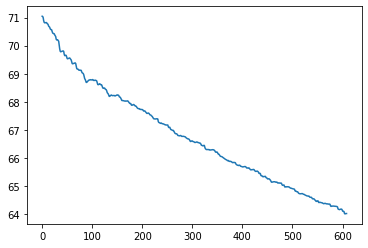

In [52]:
plt.plot(individual_scores)

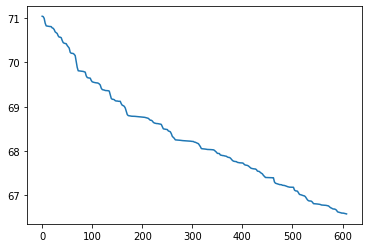

In [53]:
plt.plot(ensemble_scores)

In [55]:
individual_scores

[71.04556225877558,
 71.03747854549196,
 70.99764167662447,
 70.88957489508377,
 70.82821227516384,
 70.81134015546476,
 70.81249332433441,
 70.81909305785334,
 70.82258554608873,
 70.81473840649858,
 70.782345987421,
 70.7733504231348,
 70.74351441187851,
 70.69164983917109,
 70.6726787576153,
 70.65556647026385,
 70.60217801804646,
 70.57379945602011,
 70.57174256392757,
 70.56080269889539,
 70.49777018078382,
 70.4497127691655,
 70.43572910135256,
 70.42814061778046,
 70.42515984991893,
 70.38352800427239,
 70.35242440609956,
 70.32474057522748,
 70.23002740785428,
 70.20245833874772,
 70.20828537162586,
 70.2076820864754,
 70.18416592455662,
 70.15425709857728,
 70.0251598571881,
 69.8893874530538,
 69.80296011698641,
 69.7813481869017,
 69.7888366682277,
 69.799072113176,
 69.80621764910966,
 69.80965723203293,
 69.8123426173905,
 69.79724195568527,
 69.69670253885809,
 69.64579347446725,
 69.64853610760069,
 69.66049114504396,
 69.65179304330702,
 69.59415506389439,
 69.538984698

In [54]:
ensemble_scores

[71.04556225877558,
 71.04152030915473,
 71.03747854549196,
 71.01755388628058,
 70.99764167662447,
 70.943576976409,
 70.88957489508377,
 70.8588826253355,
 70.82821227516384,
 70.82539885691028,
 70.82258554608873,
 70.82083926290817,
 70.81909305785334,
 70.81691569977761,
 70.81473840649858,
 70.8136158549306,
 70.81249332433441,
 70.8119167388722,
 70.81134015546476,
 70.79684091843257,
 70.782345987421,
 70.77784723751486,
 70.7733504231348,
 70.75842968803458,
 70.74351441187851,
 70.71756895582541,
 70.69164983917109,
 70.68216170127528,
 70.6726787576153,
 70.66412195932837,
 70.65556647026385,
 70.6288659441251,
 70.60217801804646,
 70.5879853480045,
 70.57379945602011,
 70.57277088426221,
 70.57174256392757,
 70.56627218543785,
 70.56080269889539,
 70.52927000812984,
 70.49777018078382,
 70.47373403321451,
 70.4497127691655,
 70.44272038443707,
 70.43572910135256,
 70.43193477679745,
 70.42814061778046,
 70.42665021543826,
 70.42515984991893,
 70.40433852609979,
 70.38352800